In [268]:
import matplotlib.pyplot as plt
import numpy as np

In [269]:
g = 1

In [270]:
# Константы
# Время моделирования
T = 20
# Delta t
dt = 0.01

# Заданные параметры
T_ob = 1
Xi = 0.75
K_ob = 1
# Время запаздывания
tau_ob = 0.1

In [271]:
class AdjustableModule:
    '''Объект регулирования'''
    __y_1 = 0
    __y_2 = 0

    def calc_output(self, input_value: float):
        k_1 = dt * (self.__y_2)
        m_1 = dt * ((-2*Xi/T_ob)*self.__y_2 - 1/(T_ob**2)*self.__y_1 + K_ob/T_ob*input_value)
        k_2 = dt * (self.__y_2 + k_1 / 2)
        m_2 = dt * ((-2*Xi/T_ob)*(self.__y_2 + m_1/2) - 1/(T_ob**2)*(self.__y_1 + k_1/2) + K_ob/T_ob*input_value)
        k_3 = dt * (self.__y_2 + k_2 / 2)
        m_3 = dt * ((-2*Xi/T_ob)*(self.__y_2 + m_2/2) - 1/(T_ob**2)*(self.__y_1 + k_2/2) + K_ob/T_ob*input_value)
        k_4 = dt * (self.__y_2 + k_3)
        m_4 = dt * ((-2*Xi/T_ob)*(self.__y_2 + m_3) - 1/(T_ob**2)*(self.__y_1 + k_3) + K_ob/T_ob*input_value)
        
        self.__y_1 += (1/6) * (k_1 + 2*k_2 + 2*k_3 + k_4)
        self.__y_2 += (1/6) * (m_1 + 2*m_2 + 2*m_3 + m_4)

        return self.__y_1
    
    def __str__(self):
        return f"y_1: {self.__y_1}, y_2: {self.__y_2}"

In [272]:
t_vals = []
t = 0
y = []

ob = AdjustableModule()

while t < T:
    y_val = ob.calc_output(input_value=g)
    y.append(y_val)
    t_vals.append(t)
    t += dt

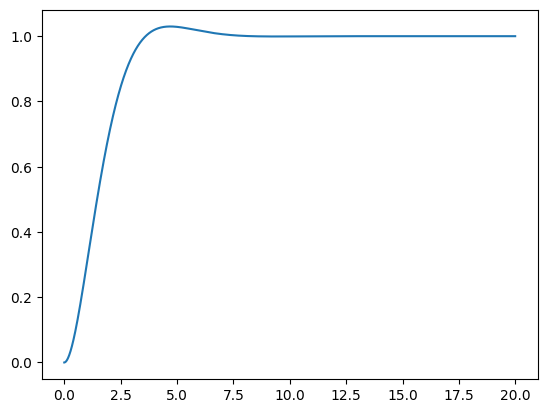

In [273]:
plt.plot(t_vals, y)

Теперь, пусть выход объекта регулирования - $` z(t) `$

In [274]:
z_values = []

Добавим звено запаздывания

In [275]:
class DelayModule:
    def __init__(self, tau: float):
        self.tau = tau
        self.input_values = []
        self.shift = int(tau / dt)

    def calc_output(self, input_value):
        self.input_values.append(input_value)
        if len(self.input_values) < self.shift:
            return 0
        return self.input_values[len(self.input_values) - self.shift]
    
    def __str__(self):
        return f"INPUT VALS {len(self.input_values)}"

In [276]:
t_vals = []
t = 0

y_values = []
z_values = []

ob = AdjustableModule()
delay_module = DelayModule(tau=tau_ob)

x = 0
y_val = 0

while t < T:
    # Обратная связь
    x = g - y_val
    z_val = ob.calc_output(input_value=x)
    z_values.append(z_val)
    y_val = delay_module.calc_output(input_value=z_val)
    y_values.append(y_val)
    t_vals.append(t)
    t += dt

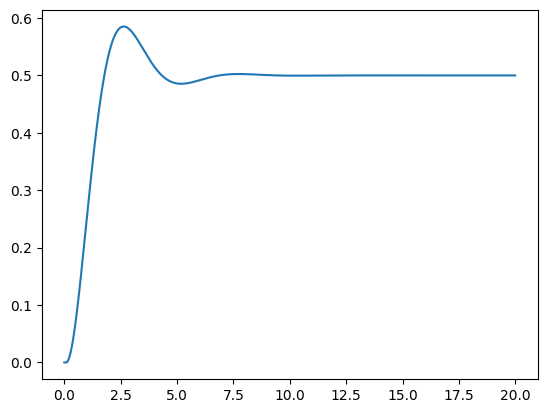

In [277]:
plt.plot(t_vals, y_values)
plt.show()

Добавим звено регулирования

In [278]:
class ControlModule:
    __integ_part = 0
    __previous_input = 0

    '''ПИД регулятор'''
    def __init__(self, q_1, q_2, q_3):
        self.q_1 = q_1
        self.q_2 = q_2
        self.q_3 = q_3

    def calc_output(self, input_value):
        self.__integ_part += input_value*dt
        input_direvative = (input_value - self.__previous_input) / dt
        output = self.q_1 + self.q_2 * self.__integ_part + self.q_3 * input_direvative
        self.__previous_input = input_value
        return output
    
    def __str__(self):
        return f"Integral: {self.__integ_part}, previous_input: {self.__previous_input}"

Теперь, пусть выход объекта регулирования - $` u(t) `$

In [279]:
T = 40

t_vals = []
t = 0

x = 0
u_val = 0
z_val = 0
y_val = 0

u_values = []
y_values = []
z_values = []

# Инициализируем веса случаными значениями
q_vals = [0.5, 0.1, 0.7]

ob = AdjustableModule()
delay_module = DelayModule(tau=tau_ob)
pid_reg = ControlModule(q_1=q_vals[0],
                        q_2=q_vals[1],
                        q_3=q_vals[2])

while t < T:
    # Обратная связь
    x = g - y_val

    u_val = pid_reg.calc_output(input_value=x)
    u_values.append(u_val)

    z_val = ob.calc_output(input_value=u_val)
    z_values.append(z_val)

    y_val = delay_module.calc_output(input_value=z_val)
    y_values.append(y_val)

    t_vals.append(t)
    t += dt

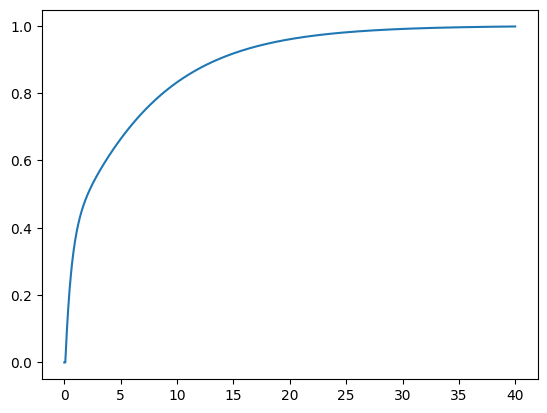

In [280]:
plt.plot(t_vals, y_values)

## Подсчет интегрального критерия качетсва

$$ I_3(t) = \int_0^t \left( x^2(t) + \mu \cdot \left( \frac{dx(t)}{dt} \right)^2 \right) dt $$

In [281]:
# Для использования сотставного интегрального критерия качества необходимо выбрать mu
# Так как t_рег / 6 <= mu < t_рег / 3

# Пока возьму случайное значение
mu = 1

In [282]:
T = 40

t_vals = []
t = 0

x = 0
u_val = 0
z_val = 0
y_val = 0

x_values = []
u_values = []
y_values = []
z_values = []

q_vals = [0.5, 0.1, 0.7]

ob = AdjustableModule()
delay_module = DelayModule(tau=tau_ob)
pid_reg = ControlModule(q_1=q_vals[0],
                        q_2=q_vals[1],
                        q_3=q_vals[2])

# Значения интегрального критерия качества
I = 0
I_values = []

while t < T:
    # Обратная связь
    x = g - y_val
    x_values.append(x)

    if len(x_values) > 1:
        dx = (x_values[-1] - x_values[-2]) / dt
    else:
        dx = 0

    # Обновление критерия качества
    I += (x**2 + mu**2 * dx**2) * dt
    I_values.append(I)


    u_val = pid_reg.calc_output(input_value=x)
    u_values.append(u_val)

    z_val = ob.calc_output(input_value=u_val)
    z_values.append(z_val)

    y_val = delay_module.calc_output(input_value=z_val)
    y_values.append(y_val)

    t_vals.append(t)
    t += dt

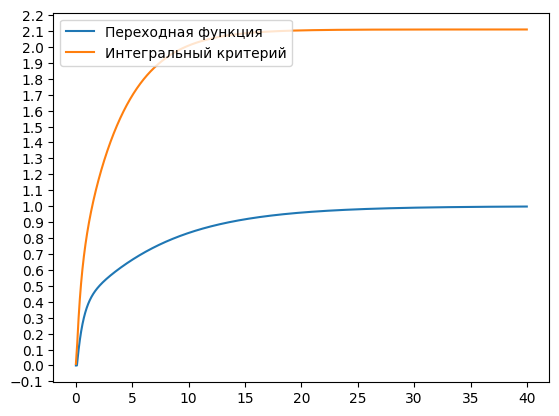

In [283]:
from matplotlib.ticker import MultipleLocator

fig = plt.figure()
ax1 = fig.add_subplot()

ax1.plot(t_vals, y_values, label='Переходная функция')
ax1.plot(t_vals, I_values, label='Интегральный критерий')
ax1.yaxis.set_major_locator(MultipleLocator(0.1))

plt.legend(loc='upper left')
plt.show()

In [ ]:
def W_ob(p):
    

In [ ]:
def criterion_q_j_direvative(x_values: np.array, dx_dt_values: np.array, W_ob, q_vals, j):
    direct_contribs = {
        "1": x_values,
        "2": np.cumsum((map(lambda x: x*dt, x_values))),
        "3": dx_dt_values
    }

    direct_contrib = direct_contribs[j]

    denominator = 1 / W_ob(1) + q_vals[0] + q_vals[1] * np.cumsum(x_values) * dt + q_vals[2] * dx_dt_values
    
    # Подынтегральное выражение
    integrand = -(2 * x_values + 2 * mu**2 * dx_dt_values) * direct_contrib / denominator
    
    # Численное интегрирование
    return np.trapezoid(integrand, dx=dt)

Для оптимизации параметров $` q_1, q_2, q_3 `$ реализуем алгоритм градиентного спуска

In [ ]:
def grad_descent(q_vals):
    # Шаг один - считаем частные производные, полученные аналитически:
    pass